In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import glob
import cv2
import os
os.chdir("..")
from loaders import get_label_mapping
from visualise import BlurAndResize

In [ ]:
datasets_folder = r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\datasets"
X_train = np.load(datasets_folder + r"\resisc45_train.npy")
y_train = np.load(datasets_folder + r"\resisc45_train_labels.npy")
mapping = get_label_mapping()

parmas = {
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : ["Computer Modern Serif"],
    "font.size" : 11
}
plt.rcParams.update(parmas)

In [ ]:
fig, axs = plt.subplots(2, 4, layout="constrained")
fig.set_size_inches((10, 6))

count = 10
for i in range(2):
    for j in range(4):
        title = mapping.get(y_train[count]).replace("_", " ")
        title = title[0].upper() + title[1:]
        axs[i, j].set_title(title)
        axs[i, j].imshow(X_train[count])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        count += 1

plt.savefig(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\report\assets\resisc45_example.png", dpi=100)

In [ ]:
fig, axs = plt.subplots(1, 6, layout="constrained")
fig.set_size_inches((10, 2))

offset = 10

for i in range(6):
    title = mapping.get(y_train[i+offset]).replace("_", " ")
    title = title[0].upper() + title[1:]
    if i == 2:
        title = "Rect. farmland"
    axs[i].set_title(title)
    axs[i].imshow(X_train[i+offset])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.savefig(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\report\assets\resisc45_example.png", dpi=100)

In [ ]:
import glob
import keras

generator_paths = [path for path in glob.glob(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\generators\*\*-lr1e-05-*\generator.keras")]
generator_dict = {path.split("\\")[6]: keras.saving.load_model(path) for path in generator_paths}

name_map = {
    "srgan-densenet201": "DenseNet201",
    "srgan-efficientnetv2l": "EfficientNetV2L",
    "srgan-inceptionresnetv2": "InceptionResNetV2",
    "srgan-inceptionv3": "InceptionV3",
    "srgan-mobilenetv2": "MobileNetV2",
    "srgan-nasnetlarge": "NASNetLarge",
    "srgan-resnet152v2": "ResNet152V2",
    "srgan-vgg22": "VGG22",
    "srgan-vgg54": "VGG54",
    "srgan-xception": "Xception"
}

for key in name_map.keys():
    generator_dict[name_map[key]] = generator_dict.pop(key)

In [ ]:
X_test = np.load(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\datasets\resisc45_test.npy")
index = 9
hr_img = X_test[index:index+1]
lr_img = BlurAndResize(4)(hr_img)

srresnet = keras.saving.load_model(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\generators\srresnet-mse\srresnet-mse-e1588-resisc45.keras")
srresnet_sr = srresnet(lr_img).numpy().astype(np.uint8)

fig, axs = plt.subplots(3, 4, layout="constrained")
fig.set_size_inches((10, 9))

axs[0, 0].imshow(hr_img[0])
axs[0, 0].set_title("High resolution")
axs[0, 0].set_yticks([])
axs[0, 0].set_xticks([])

axs[0, 1].imshow(srresnet_sr[0])
axs[0, 1].set_title("SRResNet")
axs[0, 1].set_yticks([])
axs[0, 1].set_xticks([])

row = 0
for i, model in enumerate(generator_dict.keys()):
    sr_img = generator_dict[model](lr_img).numpy().astype(np.uint8)[0]
    if (i + 2) % 4 == 0:
        row += 1
    axs[row, (i + 2) % 4].imshow(sr_img)
    axs[row, (i + 2) % 4].set_title(model)
    axs[row, (i + 2) % 4].set_yticks([])
    axs[row, (i + 2) % 4].set_xticks([])

plt.savefig(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\report\assets\model_comparison.png", dpi=100)

In [ ]:
models = ["VGG19", "Xception", "ResNet152V2", "InceptionV3", "InceptionResNetV2", "MobileNetV2", "DenseNet201", "NASNetLarge", "EfficientNetV2L"]
classifier_accuracies = [0.713, 0.79, 0.772, 0.778, 0.803, 0.713, 0.773, 0.825, 0.857]
ssim = [0.8878, 0.8934, 0.8916, 0.8973, 0.9018, 0.8928, 0.9045, 0.8930, 0.8958]
psnr = [22.85, 23.13, 22.9, 23.27, 23.39, 21.78, 23.47, 23.03, 22.54]

In [ ]:
plt.scatter(classifier_accuracies, ssim, c="black", marker=".")
plt.plot(np.unique(classifier_accuracies), np.poly1d(np.polyfit(classifier_accuracies, ssim, 1))(np.unique(classifier_accuracies)), c="black", linestyle="--", linewidth=1)
plt.ylabel("SSIM")
plt.xlabel("Classifer accuracy")
for i, label in enumerate(models):
    if label == "EfficientNetV2L":
        xytext = (-140, 0)
    else:
        xytext = (10, 0)
    plt.annotate(label, (classifier_accuracies[i], ssim[i]), va="center", textcoords="offset pixels", xytext=xytext)
plt.savefig(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\report\assets\ssim_accuracy_trend.png", dpi=100, bbox_inches="tight")
plt.show()

plt.scatter(classifier_accuracies, psnr, c="black", marker=".")
plt.plot(np.unique(classifier_accuracies), np.poly1d(np.polyfit(classifier_accuracies, psnr, 1))(np.unique(classifier_accuracies)), c="black", linestyle="--", linewidth=1)
plt.ylabel("PSNR")
plt.xlabel("Classifer accuracy")
for i, label in enumerate(models):
    if label == "EfficientNetV2L":
        xytext = (-140, 0)
    else:
        xytext = (10, 0)
    plt.annotate(label, (classifier_accuracies[i], psnr[i]), va="center", textcoords="offset pixels", xytext=xytext)
plt.savefig(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\report\assets\psnr_accuracy_trend.png", dpi=100, bbox_inches="tight")
plt.show()

In [ ]:
X_test = np.load(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\datasets\resisc45_test.npy")
y_test = np.load(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\datasets\resisc45_test_labels.npy")

images_dict = {i:[] for i in range(45)}

for img, label in zip(X_test, y_test):
    images_dict[label].append(img)

In [ ]:
fig, axs = plt.subplots(9, 5, layout="constrained")
fig.set_size_inches(10, 14)


for label in images_dict.keys():
    row = int(np.floor(label / 5))
    col = label % 5
    title = mapping[label].replace("_", " ")
    title = title[0].upper() + title[1:]

    axs[row,col].set_title(title)
    axs[row,col].set_xticks([])
    axs[row,col].set_yticks([])

    axs[row,col].imshow(images_dict[label][0])
plt.savefig(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\report\assets\resisc45_all_classes.png", dpi=100, bbox_inches="tight")

In [44]:
set5_lr = []
set5_hr = []
for file in glob.glob(r"C:\Users\nedst\Desktop\SelfExSR\data\Set5\image_SRF_4\*.png"):
    img = plt.imread(file)
    if file.split(".png")[0][-2:] == "HR":
        set5_hr.append(img)
    else:
        set5_lr.append(img)

set14_lr = []
set14_hr = []
for file in glob.glob(r"C:\Users\nedst\Desktop\SelfExSR\data\Set14\image_SRF_4\*.png"):
    img = plt.imread(file)
    if file.split(".png")[0][-2:] == "HR":
        set14_hr.append(img)
    else:
        set14_lr.append(img)

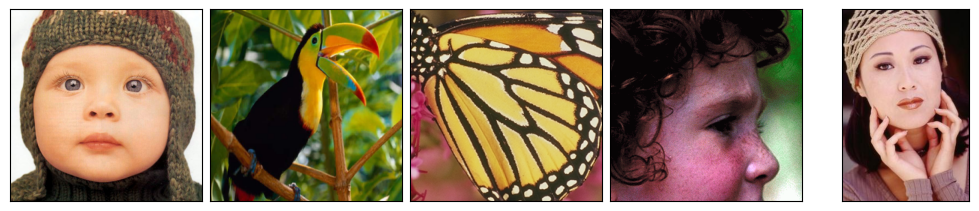

In [52]:
fig, axs = plt.subplots(1, 5, layout="constrained")
fig.set_size_inches(10, 2)

for i, img in enumerate(set5_hr):
    axs[i].imshow(img)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.savefig(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\report\assets\set5.png", dpi=100, bbox_inches="tight")

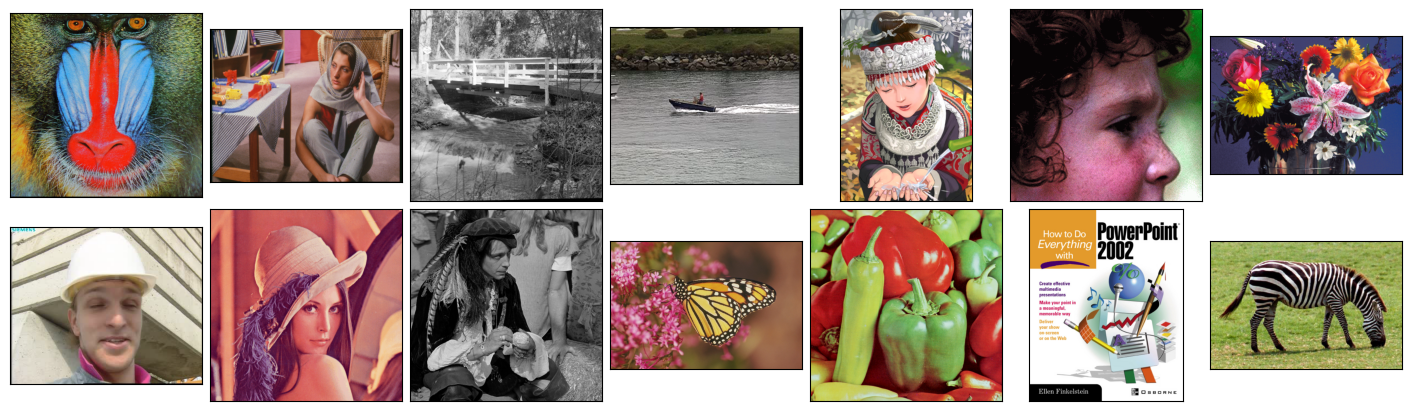

In [55]:
fig, axs = plt.subplots(2, 7, layout="constrained")
fig.set_size_inches(14, 4)

for i, img in enumerate(set14_hr):
    row = int(np.floor(i / 7))
    col = i % 7
    if i == 2:
        axs[row,col].imshow(img, cmap="gray")
    else:
        axs[row,col].imshow(img)
    axs[row,col].set_xticks([])
    axs[row,col].set_yticks([])
plt.savefig(r"C:\Users\nedst\Desktop\synoptic-project-NedStickler\report\assets\set14.png", dpi=100, bbox_inches="tight")